# LLMEyeCap: Giving Eyes to Language Models
# V 0.1
#### Novel Object Captioning Model for LLMs vision 
#### Step 0 : Novel Object Captioning + Bboxes 
#### ResNet50 as a backbone
#### Customized DETR model for bboxes bounding
#### BERT Tokenizer and GPT2 for captioning (Text Generation)
#### Replacing classification Layers by a  Transformer Decoder Object Captioning Layers
###
##### Trainend on VOC /  coco 80 and coco 91 Datasets for 30 epochs
### 
##### Imed MAGROUNE 15/009/2023

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import os
import json
import numpy as np
from collections import defaultdict
import random
from tqdm.notebook import tqdm
from torchvision import models
from torch.nn.utils.rnn import pad_sequence
import matplotlib.patches as patches

import math
import time
import os
from PIL import Image
import requests
import nltk

import os
import cv2
import colorsys
from numpy import asarray
import math

from transformers import GPT2LMHeadModel, GPT2Config

from scipy.optimize import linear_sum_assignment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# imports

In [2]:
import sys
sys.path.append("../src")

from utils import *
from model import *
from train import *


# Datset

In [3]:
# Créer les datasets
train_dataset = CocoDataset(root_dir="../data/coco91/train2017", 
                                    annotation_file="../data/coco91/annotations/captions_train2017.json", 
                                 instance_file="../data/coco91/annotations/instances_train2017.json",
                                    transform=transform)
val_dataset = CocoDataset(root_dir="../data/coco91/val2017", annotation_file="../data/coco91/annotations/captions_val2017.json", 
                                   instance_file="../data/coco91/annotations/instances_val2017.json",
                                   transform=transform)


In [4]:
batch_size=4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate)

# Show Dataset samples

In [5]:
def show_example(loader):
    img, boxes, labels = next(iter(loader)) 
    
    img = img[0].permute(1, 2, 0).numpy()  # Change the image shape to (H, W, C)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = img.clip(0, 1)  # Ensure the values are between 0 and 1

    fig, ax = plt.subplots(1, 1, figsize=(12, 20))  # Set the figure size
    
    ax.imshow(img)
    # Draw bounding boxes and labels
    
    for box, label in zip(boxes[0], labels[0]):
        # print(box)
        (x, y, w, h) = box
        if (x==0 and y==0 and w==0 and h==0) or label=='na':
            continue
        x*=256
        y*=256
        w*=256
        h*=256
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # label_str = label_map[label.item()] if label.item() in label_map else str(label.item())
        ax.text(x-w/2, y-h/2, label, color='r', bbox=dict(facecolor='white', edgecolor='r', pad=2),fontsize=18)
    


    plt.show()

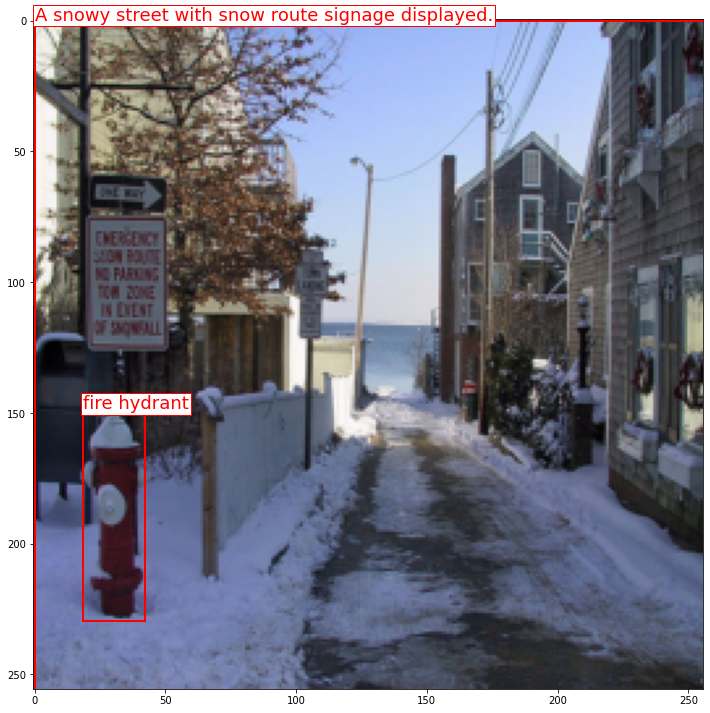

In [6]:
show_example(train_loader)

# Tokenization

In [7]:
# Initialiser le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Obtenir le token de padding et son ID
#PAD_TOKEN = tokenizer.pad_token
PAD_TOKEN = tokenizer.pad_token_id

# Obtenir le token de début de séquence et son ID
# Pour BERT, le token de début de séquence est souvent le même que le token [CLS]
#start_of_sequence_token = tokenizer.cls_token
PAD_SOS = tokenizer.cls_token_id

# Obtenir la taille du vocabulaire
vocab_size = tokenizer.vocab_size

print(f"Pad token: {PAD_TOKEN}")
print(f"Start of Sequence token: {PAD_SOS}, ID: {PAD_SOS}")
print(f"Vocab size: {vocab_size}")

Pad token: 0
Start of Sequence token: 101, ID: 101
Vocab size: 30522


# Create LLMEyeModel

In [8]:
NUM_QUERIES = 40
NULL_CLASS_COEF = 0.1
feature_size = 256  # Pour ResNet50
token_size = 256  # Pour GPT-2

In [9]:

#decoder = CaptionDecoder(feature_size, token_size, vocab_size).to(device)
model = LLMEyeCapModel(num_queries=NUM_QUERIES,vocab_size=vocab_size,pad_token=PAD_TOKEN)
model = model.to(device)

/feynman/home/dedip/lis/im267926/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/feynman/home/dedip/lis/im267926/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)


In [11]:
criterion = SetCriterion(vocab_size, matcher=matcher, weight_dict=weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses,pad_token=PAD_TOKEN)
criterion = criterion.to(device)

best_loss = 10**5

LR = 2e-6
#LR = 2e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #, weight_decay=0.0001)
EPOCHS=1
num_queries=NUM_QUERIES
batch_size=4

# Train the model

In [ ]:
for epoch in range(EPOCHS):
        time_start = time.time()
        train_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(val_loader, model,criterion, device)

        elapsed = time.time() - time_start
        chk_name = f'../model/LLMEyeCap_01_e{epoch}.bin'
        torch.save(model.state_dict(), chk_name)
        print(f"[Epoch {epoch+1:2d} / {EPOCHS:2d}] Train loss: {train_loss.avg:.3f}. Val loss: {valid_loss.avg:.3f} --> {chk_name}  [{elapsed/60:.0f} mins]")   

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print(f'Best model found in epoch {epoch+1}........Saving Model')
            torch.save(model.state_dict(), '../models/LLMEyeCap_01_model.bin')

# Load the model for inference

In [12]:
state_dict = torch.load("../models/LLMEyeCap_01.bin")

model.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
def display_image_ds(image_path, bb, ll):
    #print(len(boxes),len(boxes[0]),len(labels),len(labels[0]))
    image = Image.open(image_path).convert('RGB')
    

    fig, ax = plt.subplots(1, 1, figsize=(12, 20))  # Set the figure size
    
    ax.imshow(image)
    # Draw bounding boxes and labels
    
    for box, label in zip(bb[0], cc[0]):
        
        (x, y, w, h) = box
        if (x==0 and y==0 and w==0 and h==0) or label=='na':
            continue
        x*=image.width
        y*=image.height
        w*=image.width
        h*=image.height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_str = tokenizer.decode(label, skip_special_tokens=True)
        #print("*",label_str,"*")
        if label_str != 'na':
            ax.text(x-w/2, y-h/2, label_str, color='r', bbox=dict(facecolor='white', edgecolor='r', pad=2),fontsize=18)

In [27]:
image_paths=["../data/coco91/train2017/000000291557.jpg", "../data/coco91/train2017/000000436027.jpg"]

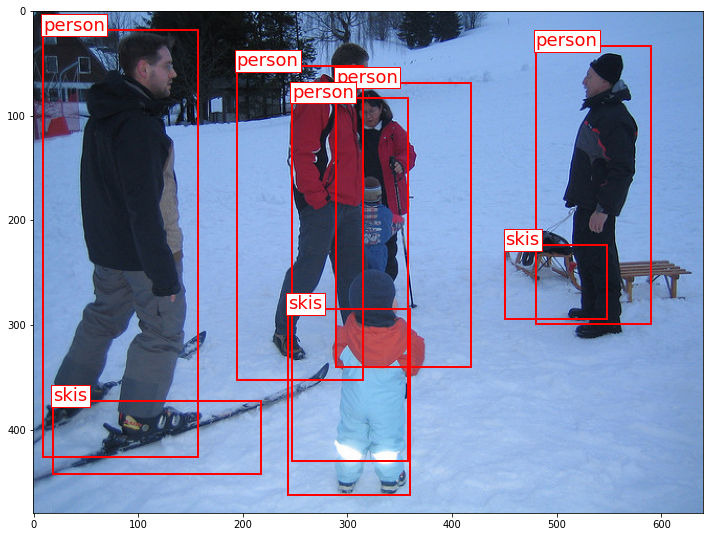

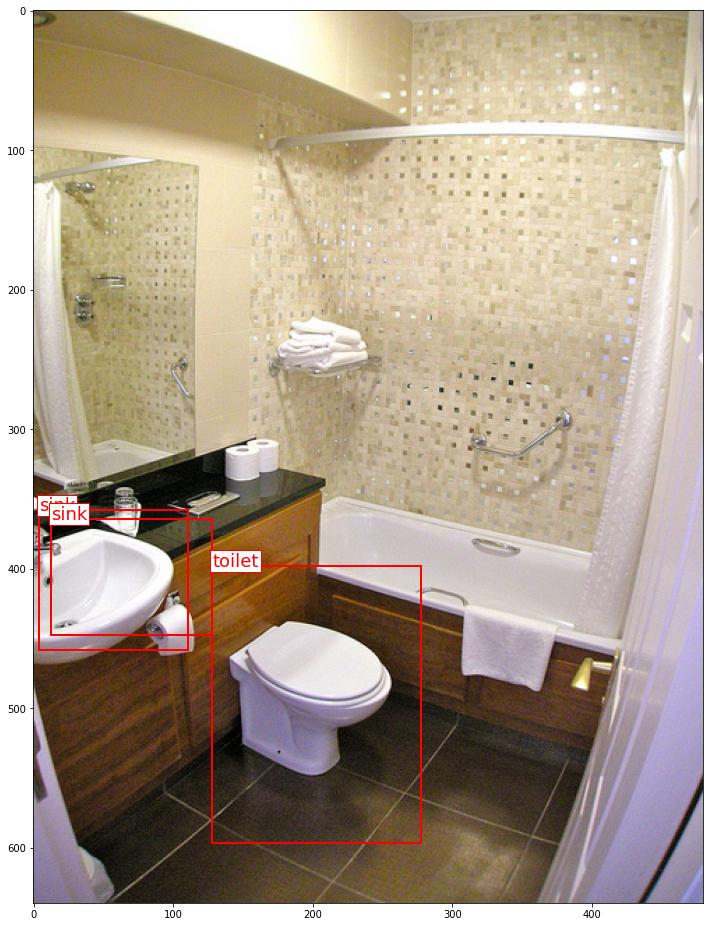

In [28]:
for im in image_paths:
    bb,cc= model.generate_caption( im, tokenizer, max_length=20,pad_sos=PAD_SOS)
    display_image_ds(im, bb.to('cpu'), cc.to('cpu'))